# Feature Selection
Time to exact some audio features! I'm going to be using the python package librosa to extract and visualize the mel spectrogram, chroma features, and mel-frequency cepstral coefficients.

In [1]:
# Import Packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import json

# Audio Processing
import librosa
import librosa.feature as lf
import librosa.display as ld
import sounddevice as sd
import soundfile as sf

In [2]:
# open the legend
data = pd.read_csv('Data/CSVs/Audio Legend Clean.csv',index_col='Unnamed: 0')
purple = [0.267004, 0.004874, 0.329415, 1.]

# Get Features
open wav files and save features in a dataframe.

In [3]:
columns = ['filename','audio','sample rate','mel spectrogram','chroma','mel cepstral']

audio = pd.DataFrame(columns=columns)
error = []

folders = 'Data/Audio/Clean/'
for count,track in enumerate(data['filename'],start=1):
    # get autio and sample rate
    path = folders+track
    clip, samplerate = librosa.load(path, sr=16000)
    try:
        L = [track,clip,samplerate,
             lf.melspectrogram(clip,samplerate),      # mel-frequency spectrogram
             lf.chroma_stft(clip,samplerate),         # chroma features
             lf.mfcc(clip,samplerate)]               # mel-frequency cepstral coefficients
        audio = audio.append(dict(zip(columns,L)),ignore_index=True)
    except:
        error.append(track)
    
    # progress bar
    print('%4d of %4d complete (%d%%)' % (count,len(data['filename']),(count/len(data['filename']))*100)
          ,end='\r')
    
audio = audio.set_index('filename')
audio.head(3)

,audio,sample rate,mel spectrogram,chroma,mel cepstral
filename,,,,,
Clip_0000.wav,"[0.0053100586, 0.0051574707, 0.0054016113, 0.0...",16000,"[[0.002243551, 0.011167973, 0.026370432, 0.006...","[[0.31399313, 0.3416271, 0.29401675, 0.0826690...","[[-173.28368, -54.43142, -14.931408, -36.94705..."
Clip_0001.wav,"[0.0020446777, -0.00039672852, -0.0011291504, ...",16000,"[[0.0011843091, 0.0028443562, 0.0011252087, 0....","[[0.87314206, 0.7617242, 0.9011862, 0.7413292,...","[[-189.0959, -135.91434, -110.33126, -131.5426..."
Clip_0002.wav,"[0.0064086914, 0.0051574707, 0.0073547363, 0.0...",16000,"[[0.017193925, 0.030587701, 0.011005114, 0.001...","[[0.48194504, 0.24107023, 0.18023169, 0.284793...","[[-89.319405, -39.952785, -37.663242, -79.6460..."


# Visualize Features

In [4]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

# set some variables for the plots
dpi = 200
width = 8
fig_path = 'Data/Plots/'

# Get a random audio clip
random_clip = np.random.permutation(audio.index.values)[0]
test = audio.loc[random_clip]
print(data[data['filename'] == random_clip][['original','statement','emotion']])

                 original  statement  emotion
3321  1041_TIE_NEU_XX.wav         12  neutral


In [5]:
# Uncomment to hear the audio clip
#sd.play(test['audio'], test['sample rate'])
#status = sd.wait()

### Waveform
The waveform is the general shape of the audio clip over time. This wont be included as a feature for modeling, but it's still nice to visualize and compare with the other features.

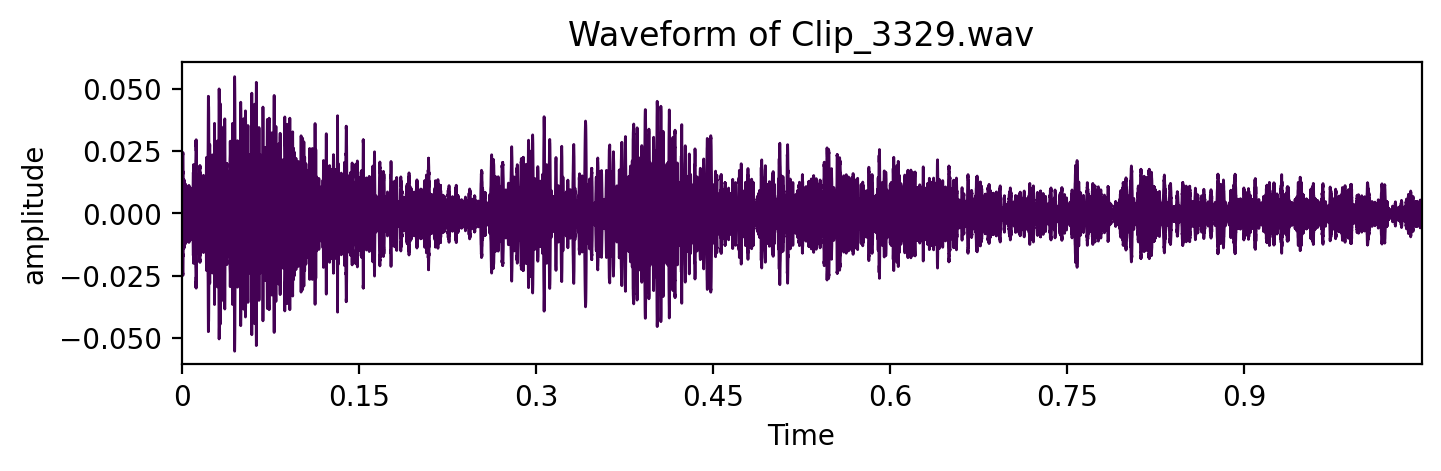

In [6]:
wave = test['audio']
sample_rate = test['sample rate']

FEAT_WAV = plt.figure(figsize=(width,2),dpi=dpi)
ld.waveplot(wave, sr=sample_rate,color=purple)
plt.title('Waveform of %s' % random_clip)
plt.ylabel('amplitude')

FEAT_WAV.savefig(fig_path+'FEAT Waveform', bbox_inches='tight');

### Mel-Frequency Spectrogram
A visualization of how the spectrum of frequencies changes over time. This spectrogram in particular utilizes the mel scale, which is a scale of pitches based on human hearing. 

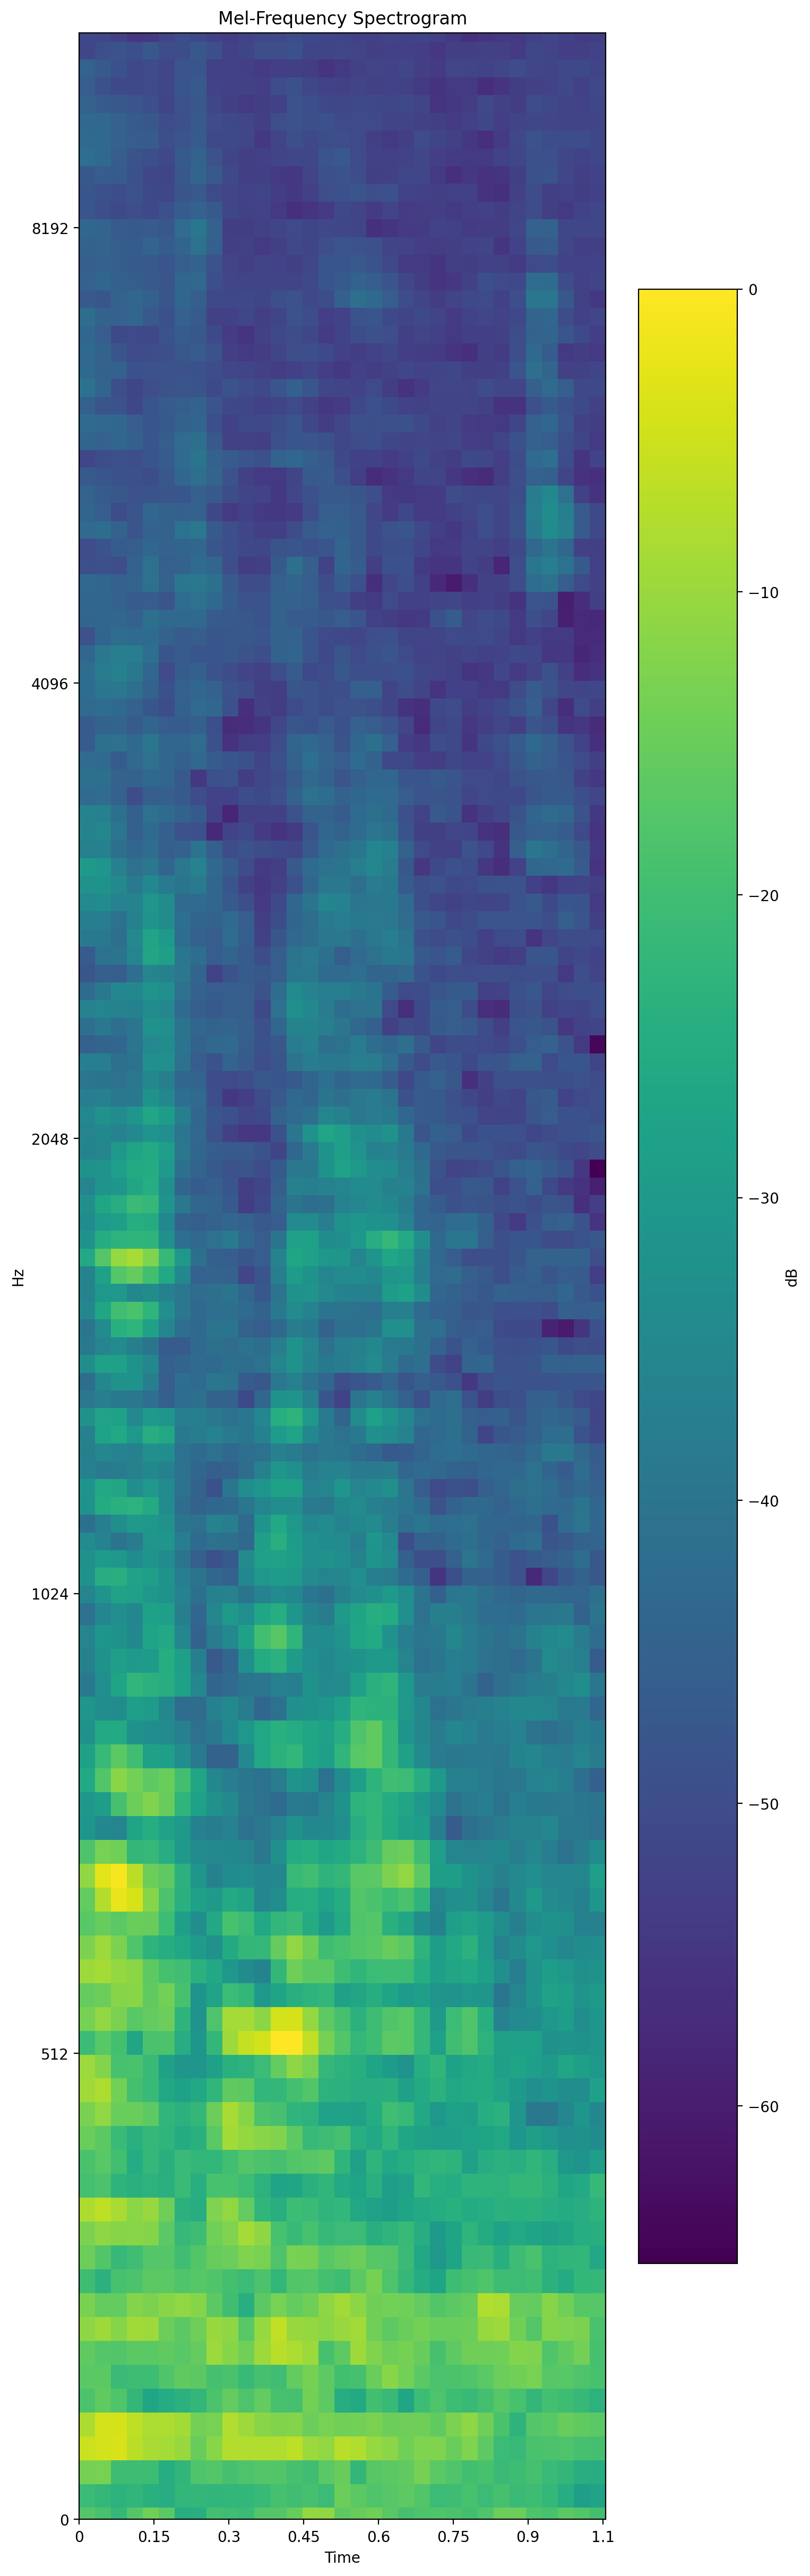

In [7]:
shape_y,shape_x = test['mel spectrogram'].shape
shape_y = (width/shape_x)*shape_y

FEAT_MFS = plt.figure(figsize=(width,shape_y),dpi=dpi)
S_dB = librosa.power_to_db(test['mel spectrogram'], ref=np.max)
librosa.display.specshow(data=S_dB,sr=sample_rate, x_axis='time',y_axis='mel',cmap='viridis')
plt.colorbar(label='dB')
plt.title('Mel-Frequency Spectrogram')

FEAT_MFS.savefig(fig_path+'FEAT Spectrogram', bbox_inches='tight');

### Mel-Frequency Cepstral Coefficients
Displays the coefficients that make up the short-term power spectrum of a sound.

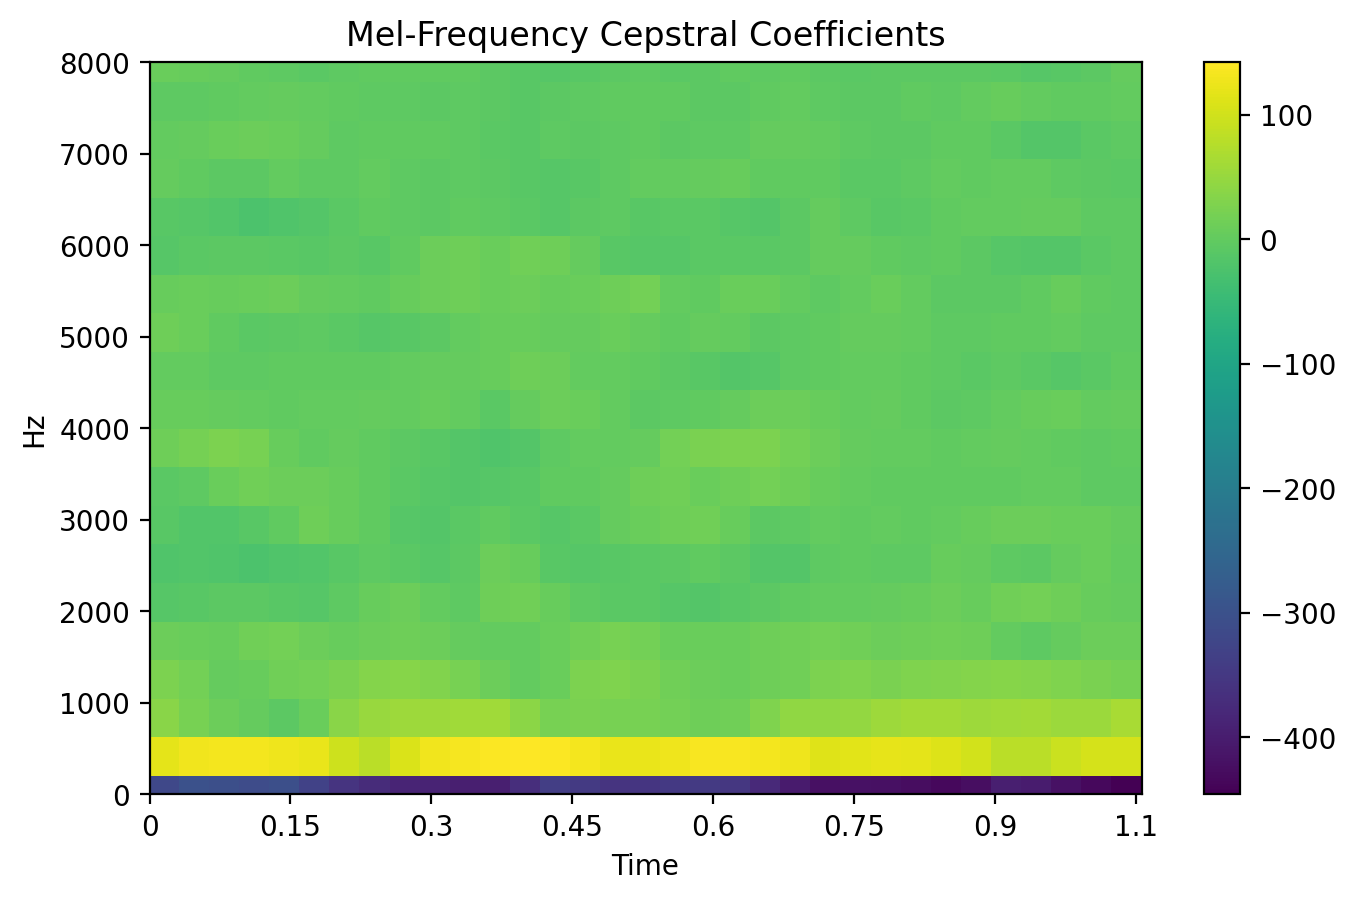

In [8]:
shape_y,shape_x = test['mel cepstral'].shape
shape_y = (width/shape_x)*shape_y

FEAT_MCC = plt.figure(figsize=(width,shape_y),dpi=dpi)
ax=plt.subplot(111)
ld.specshow(test['mel cepstral'], sr=sample_rate, x_axis='time', y_axis='hz',cmap='viridis')
plt.title('Mel-Frequency Cepstral Coefficients')
plt.colorbar()

FEAT_MCC.savefig(fig_path+'FEAT Cepstral', bbox_inches='tight');

### Chromagram
Represents how the pitch changes over time.

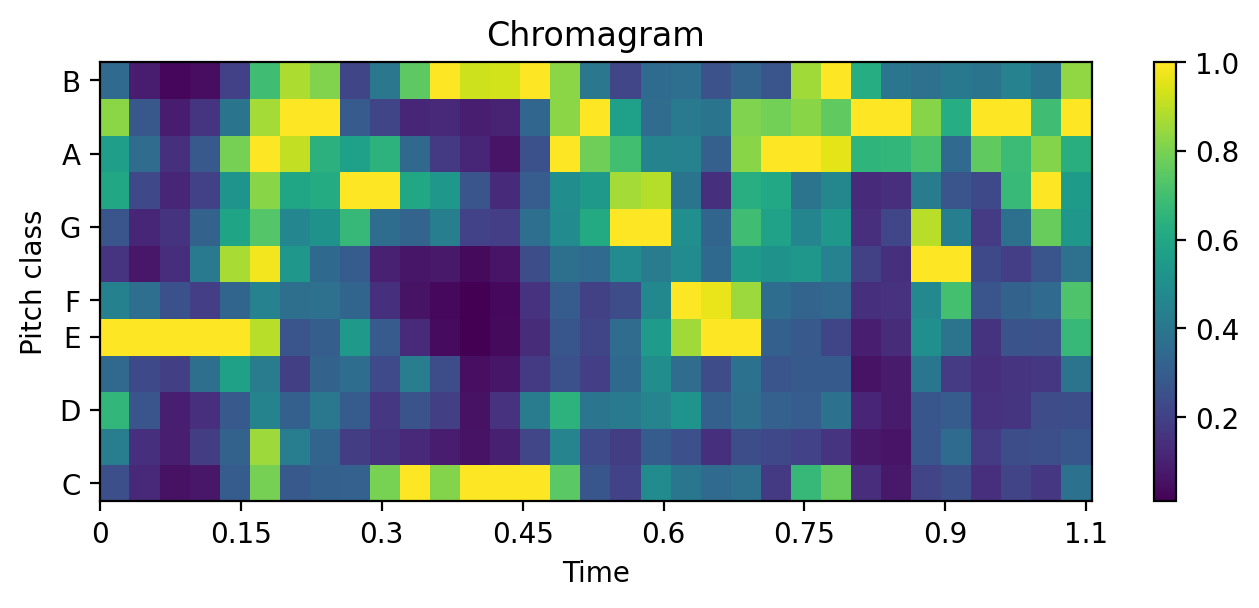

In [9]:
shape_y,shape_x = test['chroma'].shape
shape_y = (width/shape_x)*shape_y

FEAT_CRM = plt.figure(figsize=(width,shape_y),dpi=dpi)
ld.specshow(test['chroma'], sr=sample_rate, x_axis='time', y_axis='chroma',cmap='viridis')
plt.title('Chromagram')
plt.colorbar()

FEAT_CRM.savefig(fig_path+'FEAT Chromagram', bbox_inches='tight');

# Prep and Save
normalize the data feature-wise and add padding so that each entry is the same size.

In [10]:
# drop unnecessary
final = audio.drop(columns=['audio','sample rate'])
# convert mel spectrogram to decibels
final['mel spectrogram'] = [librosa.power_to_db(entry, ref=np.max) for entry in audio['mel spectrogram']]

In [11]:
def min_max(data,column):
    '''returns the global min and max of the whole column'''
    local_min = []
    local_max = []
    for entry in data[column]:
        local_min.append(np.amin(entry))
        local_max.append(np.amax(entry))
    return np.float64(min(local_min)), np.float64(max(local_max))

# normalize by feature
def normalize(data,column):
    feat_min,feat_max = min_max(data,column)
    array = data[column].to_numpy()
    array = (array-feat_min)/(feat_max-feat_min)
    return array, {'min':feat_min,'max':feat_max}

def concat(data,columns):
    new_col = []
    for index in data.index:
        for column in columns:
            entry = data.loc[index][column]
            if column == columns[0]:
                flat_entry = entry
            else:
                flat_entry = np.concatenate((flat_entry,entry),axis=0)
        new_col.append(flat_entry)
    return new_col

In [12]:
print('Normalizing Features')
norm_scale = dict()
for column in columns[3:]:
    norm, mnmx = normalize(final,column)
    norm_scale[column] = mnmx
    final[column] = norm

with open('Data/Model Config/Scale_Config.json', 'w') as fp:
    json.dump(norm_scale, fp)
print('%-25s\n' % 'Complete!') 

print('Combining Images')
final['final'] = concat(final,columns[3:])
print('%-25s\n' % 'Complete!') 

Normalizing Features
Complete!                

Combining Images
Complete!                



In [13]:
print('Padding Images')
max_len = 140
for index in final.index:
    entry = final.loc[index]['final']
    matrix = []
    if entry.shape[1] < max_len:
        zeros = max_len - entry.shape[1]
        front = int(zeros/2)
        back = int(zeros-front)
        matrix = np.pad(entry, ((0,0),(front,back)))
    if entry.shape[1] == max_len:
        matrix = entry
    final.loc[index]['final'] = matrix
print('%-25s\n' % 'Complete!')

Padding Images
Complete!                



In [14]:
# save images
print('Saving Images')
for count,index in enumerate(final.index,start=1):
    entry = final.loc[index]['final']
    path = 'Data/Images/%s.png' % (index[:-4])
    plt.imsave(path,entry)
    print('%4d of %d complete (%d%%)' % (count,len(final.index),(count/len(final.index))*100),end='\r')
print('%-30s' % ('Complete!')) 

Saving Images
Complete!                     


# Example of Final

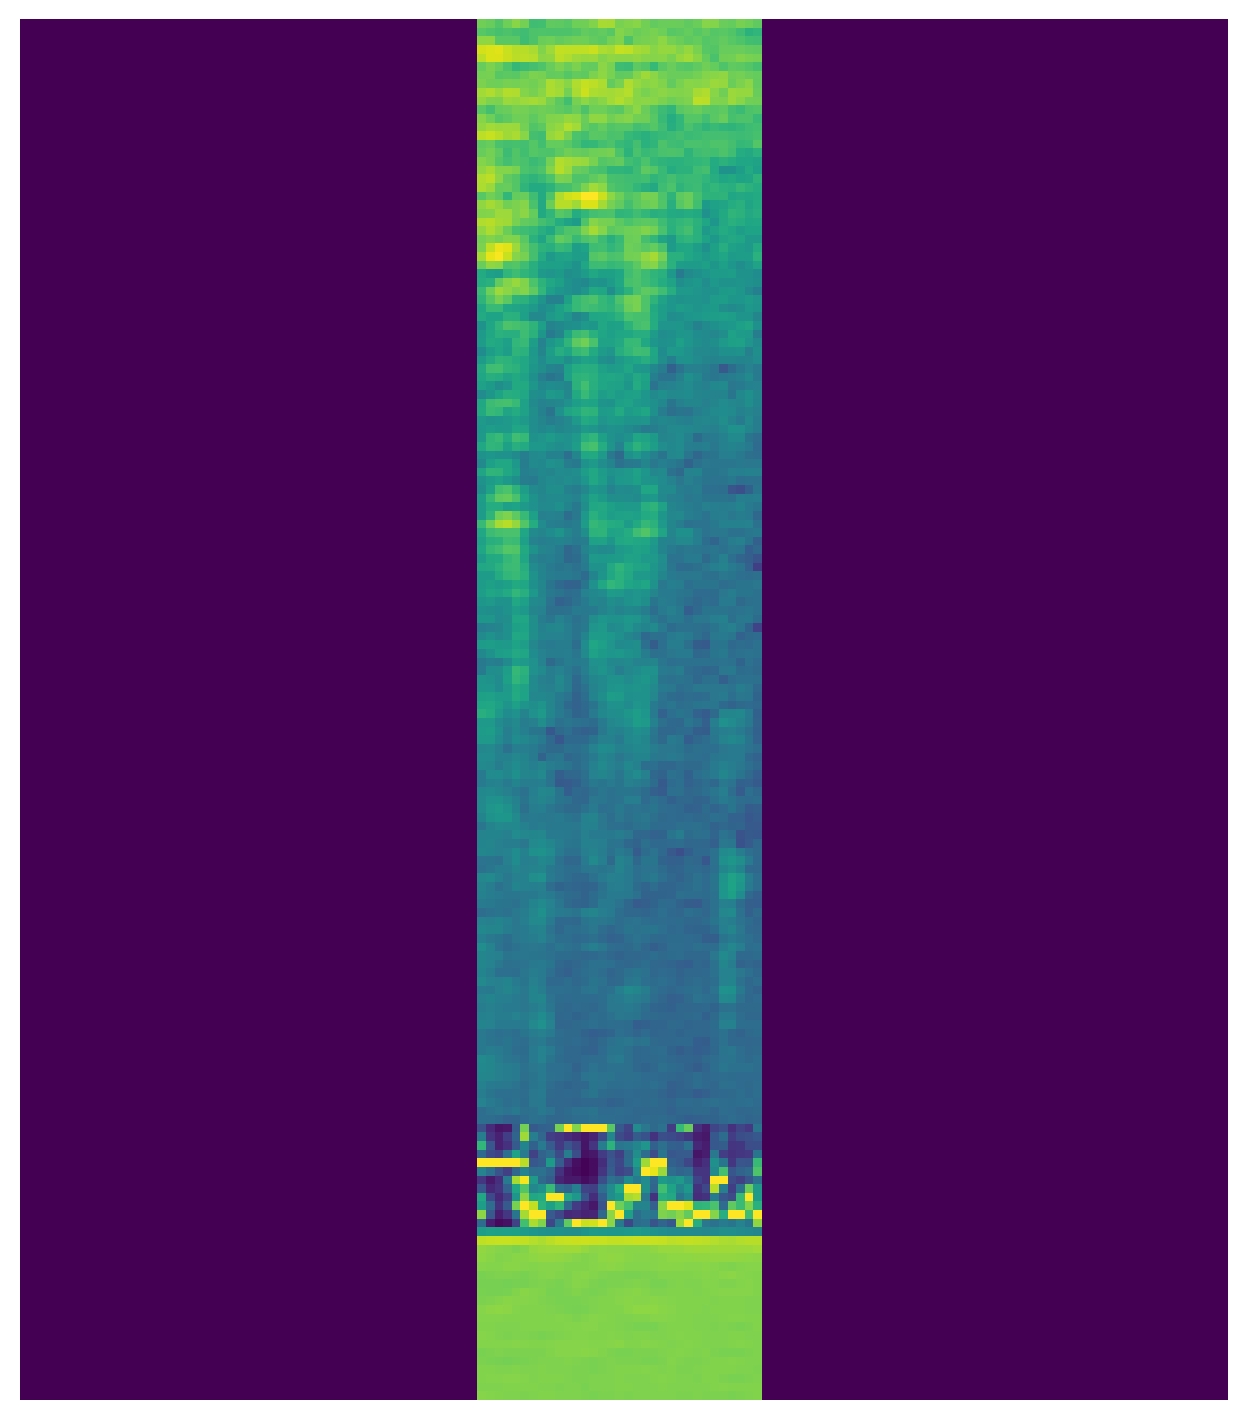

In [15]:
example = final.loc[random_clip]['final']

shape_y,shape_x = example.shape
shape_y = (width/shape_x)*shape_y

FEAT_FNL = plt.figure(figsize=(width,shape_y),dpi=dpi)
plt.imshow(example)
plt.axis('off')

FEAT_FNL.savefig(fig_path+'FEAT final img', bbox_inches='tight');